In [12]:
%load_ext autoreload
%autoreload 2
from utils import *
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
twitter_db = connect_to_db()

In [142]:
N = 1000
G_dict = dict()

cursor = twitter_db.cursor()

query = ("SELECT user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id \
        FROM tweets WHERE lang='fr' LIMIT " + str(N))

cursor.execute(query)

for (user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id) in cursor:
    #print(user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id)
    if user_id not in G_dict:
        G_dict[user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        
    if not(in_reply_to_user_id is None):
        if in_reply_to_user_id not in G_dict:
            G_dict[in_reply_to_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if in_reply_to_user_id not in G_dict[user_id]['replied_to']:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] = 1
        else:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] += 1
            
    if not(quoted_user_id is None):
        if quoted_user_id not in G_dict:
            G_dict[quoted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if quoted_user_id not in G_dict[user_id]['quoted']:
            G_dict[user_id]['quoted'][quoted_user_id] = 1
        else:
            G_dict[user_id]['quoted'][quoted_user_id] += 1
    
    if not(retweeted_user_id is None):
        if retweeted_user_id not in G_dict:
            G_dict[retweeted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if retweeted_user_id not in G_dict[user_id]['retweeted']:
            G_dict[user_id]['retweeted'][retweeted_user_id] = 1
        else:
            G_dict[user_id]['retweeted'][retweeted_user_id] += 1
    
cursor.close()       

True

In [136]:
G = nx.DiGraph()
G.add_nodes_from(G_dict.keys())

for (u1,v) in G_dict.items():
    for (u2, count) in v['quoted'].items():
        #print("quoted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='quoted',weight=count)
    for (u2, count) in v['replied_to'].items():
        #print("replied to : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='replied_to',weight=count)
    for (u2, count) in v['retweeted'].items():
        #print("retweeted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='retweeted',weight=count)

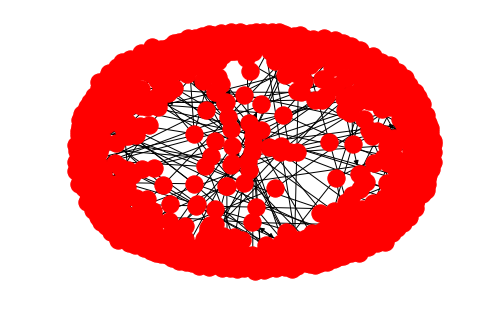

In [137]:
nx.draw(G)

In [138]:
G_undirected = nx.Graph(G)

In [139]:
partition = community.best_partition(G_undirected)

In [140]:
np.unique(np.array(list(partition.values())))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


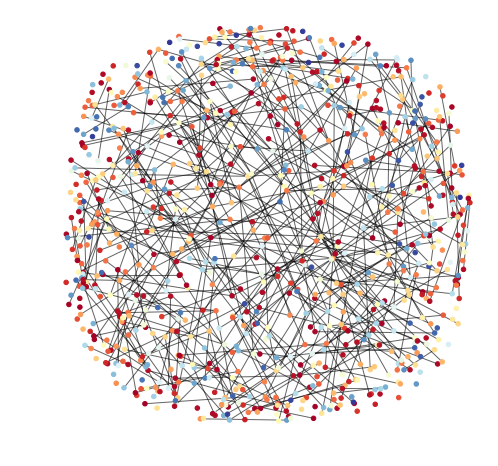

In [141]:
pos = nx.spring_layout(G_undirected,k=0.15,iterations=20)  # compute graph layout
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G_undirected, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G_undirected, pos, alpha=0.6)
plt.show(G)

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


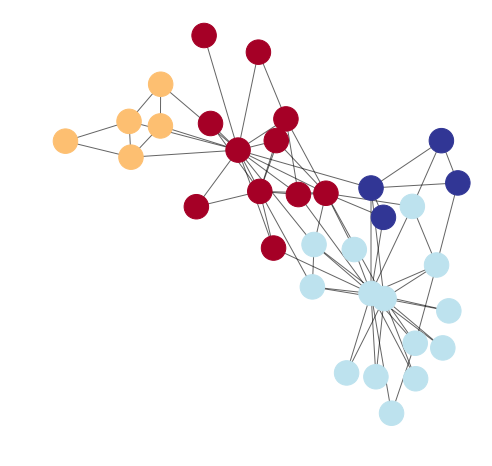

In [121]:
G = nx.karate_club_graph()  # load a default graph

partition = community.best_partition(G)  # compute communities

pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.6)
plt.show(G)